## import, preprocess and split data

In [15]:
import warnings
warnings.filterwarnings("ignore")


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Set file paths
train_path = r"C:\Users\yanxinda\Desktop\deep learning\assignment3\archive\Google_Stock_Price_Train.csv"
test_path = r"C:\Users\yanxinda\Desktop\deep learning\assignment3\archive\Google_Stock_Price_Test.csv"

# Load training and test data, specifying that commas are used as thousands separators
train_data = pd.read_csv(train_path, thousands=',')
test_data = pd.read_csv(test_path, thousands=',')

# Check for missing values
print("Missing values check (Training set):\n", train_data.isnull().sum())
print("Missing values check (Test set):\n", test_data.isnull().sum())

Missing values check (Training set):
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Missing values check (Test set):
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [ ]:
# Select the desired features : 'Open', 'High', 'Low', 'Close', 'Volume'
features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Normalize the training, validation, and test sets
scaler = MinMaxScaler(feature_range=(0, 1))
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])

# Split the original training data into new training and validation sets 
train_size = int(len(train_data) * 0.8)
train_set = train_data[:train_size]
val_set = train_data[train_size:]

# Convert data to numpy arrays
train_array = train_set[features].values
val_array = val_set[features].values
test_array = test_data[features].values

# Generate time series samples
def create_sequences(data, lookback=10):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback, :])
        y.append(data[i + lookback, 3])  
    return np.array(X), np.array(y)

# Generate training, validation, and test sequences
lookback = 10  # Use past 10 days of data
X_train, y_train = create_sequences(train_array, lookback)
X_val, y_val = create_sequences(val_array, lookback)
X_test, y_test = create_sequences(test_array, lookback)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (996, 10, 5) y_train: (996,)
X_val: (242, 10, 5) y_val: (242,)
X_test: (10, 10, 5) y_test: (10,)


## RNN

In [ ]:
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

import numpy as np

# Define the parameter grid manually
param_grid = {
    'units': [50, 100],
    'layers': [1, 2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32]
}

# Function to build RNN model with specified parameters
def build_rnn_model(units, layers, learning_rate, input_shape):
    model = Sequential()
    for _ in range(layers - 1):
        model.add(SimpleRNN(units=units, return_sequences=True, input_shape=input_shape))
    model.add(SimpleRNN(units=units))  
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Store results
results = []

# Perform manual grid search
for units, layers, learning_rate, batch_size in itertools.product(
        param_grid['units'], param_grid['layers'], param_grid['learning_rate'], param_grid['batch_size']):
    
    print(f"Training with units={units}, layers={layers}, learning_rate={learning_rate}, batch_size={batch_size}")
    model = build_rnn_model(units=units, layers=layers, learning_rate=learning_rate, input_shape=input_shape)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Reverse scaling to get original values
    y_val_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val_pred.shape[0], 3)), y_val_pred, np.zeros((y_val_pred.shape[0], 1))), axis=1))[:, 3]
    y_val_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val.shape[0], 3)), y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 1))), axis=1))[:, 3]
    
    # Calculate MSE on the original scale
    val_loss_rescaled = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    
    # Save the results
    results.append({
        'units': units,
        'layers': layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss_rescaled': val_loss_rescaled
    })
    print(f"Validation Loss (rescaled): {val_loss_rescaled}")

# Find the best parameters
best_params = min(results, key=lambda x: x['val_loss_rescaled'])
print("Best parameters:", best_params)



Training with units=50, layers=1, learning_rate=0.001, batch_size=16
8/8 [==============================] - 0s 3ms/step
Validation Loss (rescaled): 256.2337860633835
Training with units=50, layers=1, learning_rate=0.001, batch_size=32
8/8 [==============================] - 0s 3ms/step
Validation Loss (rescaled): 205.59966357116085
Training with units=50, layers=1, learning_rate=0.01, batch_size=16
8/8 [==============================] - 0s 4ms/step
Validation Loss (rescaled): 563.795786717507
Training with units=50, layers=1, learning_rate=0.01, batch_size=32
8/8 [==============================] - 0s 2ms/step
Validation Loss (rescaled): 179.49363646951662
Training with units=50, layers=2, learning_rate=0.001, batch_size=16
8/8 [==============================] - 0s 4ms/step
Validation Loss (rescaled): 959.5932449075816
Training with units=50, layers=2, learning_rate=0.001, batch_size=32
8/8 [==============================] - 0s 3ms/step
Validation Loss (rescaled): 171.11096012838246
Trai

## GRU

In [ ]:
from tensorflow.keras.layers import GRU

# Function to build GRU model with specified parameters
def build_gru_model(units, layers, learning_rate, input_shape):
    model = Sequential()
    for _ in range(layers - 1):
        model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))
    model.add(GRU(units=units))  
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Store results for GRU
gru_results = []

# Perform manual grid search for GRU
for units, layers, learning_rate, batch_size in itertools.product(
        param_grid['units'], param_grid['layers'], param_grid['learning_rate'], param_grid['batch_size']):
    
    print(f"Training GRU with units={units}, layers={layers}, learning_rate={learning_rate}, batch_size={batch_size}")
    model = build_gru_model(units=units, layers=layers, learning_rate=learning_rate, input_shape=input_shape)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Reverse scaling to get original values
    y_val_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val_pred.shape[0], 3)), y_val_pred, np.zeros((y_val_pred.shape[0], 1))), axis=1))[:, 3]
    y_val_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val.shape[0], 3)), y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 1))), axis=1))[:, 3]
    
    # Calculate MSE on the original scale
    val_loss_rescaled = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    
    # Save the results
    gru_results.append({
        'units': units,
        'layers': layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss_rescaled': val_loss_rescaled
    })
    print(f"GRU Validation Loss (rescaled): {val_loss_rescaled}")

# Find the best parameters for GRU
best_gru_params = min(gru_results, key=lambda x: x['val_loss_rescaled'])
print("Best parameters for GRU:", best_gru_params)


Training GRU with units=50, layers=1, learning_rate=0.001, batch_size=16


8/8 [==============================] - 1s 5ms/step
GRU Validation Loss (rescaled): 103.62096398698591
Training GRU with units=50, layers=1, learning_rate=0.001, batch_size=32
8/8 [==============================] - 0s 3ms/step
GRU Validation Loss (rescaled): 154.6988934119369
Training GRU with units=50, layers=1, learning_rate=0.01, batch_size=16
8/8 [==============================] - 0s 3ms/step
GRU Validation Loss (rescaled): 109.64550059218175
Training GRU with units=50, layers=1, learning_rate=0.01, batch_size=32
8/8 [==============================] - 0s 2ms/step
GRU Validation Loss (rescaled): 256.3076473375707
Training GRU with units=50, layers=2, learning_rate=0.001, batch_size=16
8/8 [==============================] - 1s 4ms/step
GRU Validation Loss (rescaled): 118.83398679766324
Training GRU with units=50, layers=2, learning_rate=0.001, batch_size=32
8/8 [==============================] - 1s 4ms/step
GRU Validation Loss (rescaled): 106.98589963356544
Training GRU with units=50,

## LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

# Function to build LSTM model with specified parameters
def build_lstm_model(units, layers, learning_rate, input_shape):
    model = Sequential()
    for _ in range(layers - 1):
        model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=units))  
    model.add(Dense(units=1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Store results for LSTM
lstm_results = []

# Perform manual grid search for LSTM
for units, layers, learning_rate, batch_size in itertools.product(
        param_grid['units'], param_grid['layers'], param_grid['learning_rate'], param_grid['batch_size']):
    
    print(f"Training LSTM with units={units}, layers={layers}, learning_rate={learning_rate}, batch_size={batch_size}")
    model = build_lstm_model(units=units, layers=layers, learning_rate=learning_rate, input_shape=input_shape)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Reverse scaling to get original values
    y_val_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val_pred.shape[0], 3)), y_val_pred, np.zeros((y_val_pred.shape[0], 1))), axis=1))[:, 3]
    y_val_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_val.shape[0], 3)), y_val.reshape(-1, 1), np.zeros((y_val.shape[0], 1))), axis=1))[:, 3]
    
    # Calculate MSE on the original scale
    val_loss_rescaled = mean_squared_error(y_val_rescaled, y_val_pred_rescaled)
    
    # Save the results
    lstm_results.append({
        'units': units,
        'layers': layers,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'val_loss_rescaled': val_loss_rescaled
    })
    print(f"LSTM Validation Loss (rescaled): {val_loss_rescaled}")

# Find the best parameters for LSTM
best_lstm_params = min(lstm_results, key=lambda x: x['val_loss_rescaled'])
print("Best parameters for LSTM:", best_lstm_params)


Training LSTM with units=50, layers=1, learning_rate=0.001, batch_size=16
8/8 [==============================] - 1s 4ms/step
LSTM Validation Loss (rescaled): 226.68221547812138
Training LSTM with units=50, layers=1, learning_rate=0.001, batch_size=32
8/8 [==============================] - 0s 4ms/step
LSTM Validation Loss (rescaled): 727.7508363304436
Training LSTM with units=50, layers=1, learning_rate=0.01, batch_size=16
8/8 [==============================] - 0s 4ms/step
LSTM Validation Loss (rescaled): 102.19378076570894
Training LSTM with units=50, layers=1, learning_rate=0.01, batch_size=32
8/8 [==============================] - 0s 3ms/step
LSTM Validation Loss (rescaled): 228.6979627792796
Training LSTM with units=50, layers=2, learning_rate=0.001, batch_size=16
8/8 [==============================] - 1s 6ms/step
LSTM Validation Loss (rescaled): 821.781469828889
Training LSTM with units=50, layers=2, learning_rate=0.001, batch_size=32
8/8 [==============================] - 1s 5ms/s

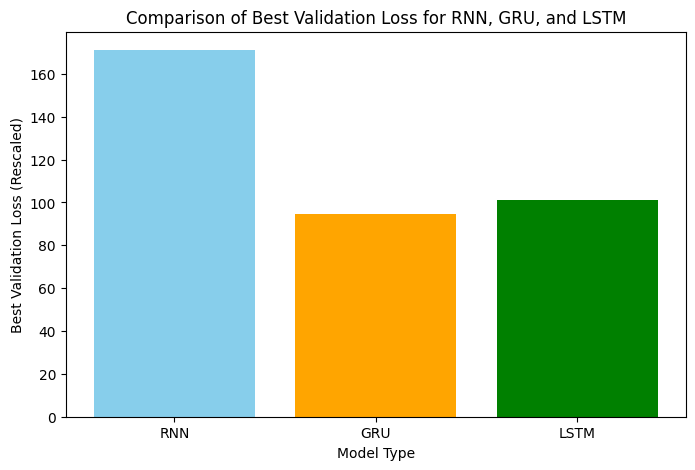

In [8]:
import matplotlib.pyplot as plt

# Best validation loss results for each model type from the previous grid search results
best_results = {
    "RNN": best_params['val_loss_rescaled'],
    "GRU": best_gru_params['val_loss_rescaled'],
    "LSTM": best_lstm_params['val_loss_rescaled']
}

# Plotting the comparison
plt.figure(figsize=(8, 5))
plt.bar(best_results.keys(), best_results.values(), color=['skyblue', 'orange', 'green'])
plt.title("Comparison of Best Validation Loss for RNN, GRU, and LSTM")
plt.xlabel("Model Type")
plt.ylabel("Best Validation Loss (Rescaled)")
plt.show()


In [7]:
best_gru_params

{'units': 50,
 'layers': 2,
 'learning_rate': 0.01,
 'batch_size': 16,
 'val_loss_rescaled': 94.77714124664996}

Epoch 1/50
78/78 [==============================] - 6s 13ms/step - loss: 0.0302
Epoch 2/50
78/78 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 3/50
78/78 [==============================] - 1s 11ms/step - loss: 0.0011
Epoch 4/50
78/78 [==============================] - 1s 13ms/step - loss: 0.0011
Epoch 5/50
78/78 [==============================] - 1s 11ms/step - loss: 9.8214e-04
Epoch 6/50
78/78 [==============================] - 1s 12ms/step - loss: 9.8235e-04
Epoch 7/50
78/78 [==============================] - 1s 12ms/step - loss: 8.9229e-04
Epoch 8/50
78/78 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 9/50
78/78 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 10/50
78/78 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 11/50
78/78 [==============================] - 1s 13ms/step - loss: 9.9612e-04
Epoch 12/50
78/78 [==============================] - 1s 12ms/step - loss: 0.0012
Epoch 13/50
78/78 [==

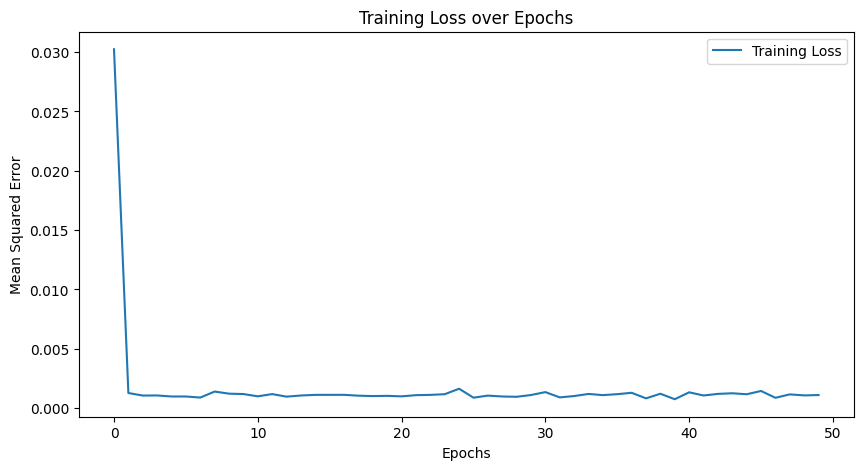

1/1 [==============================] - 1s 818ms/step
Test MSE for Best GRU Model: 85.9803193691655


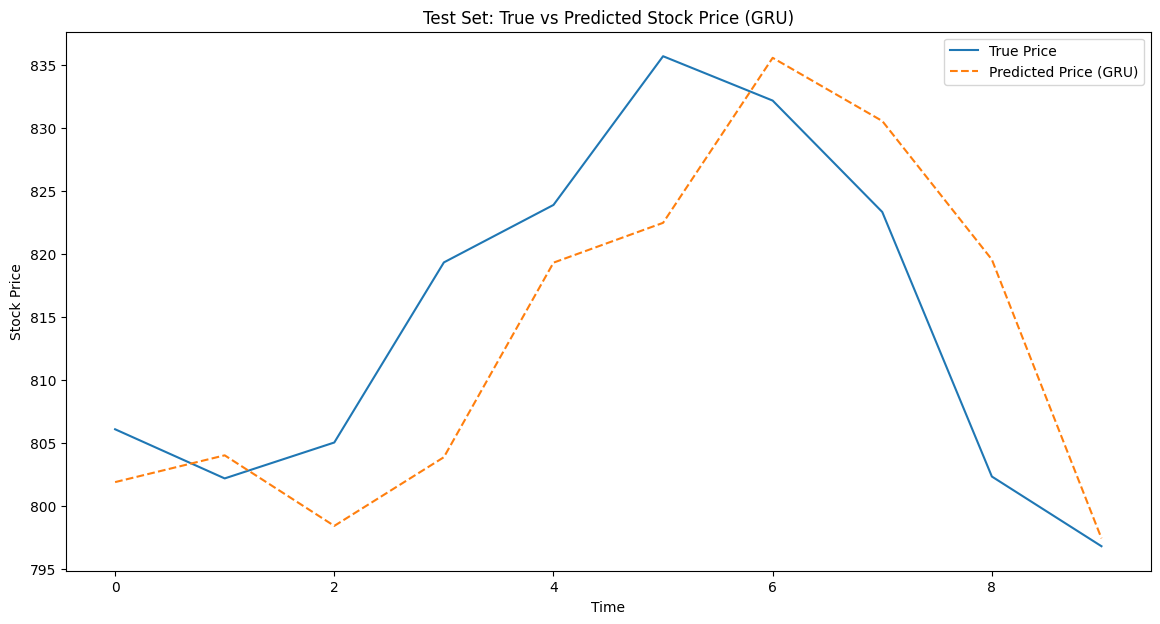

In [ ]:
from tensorflow.keras.layers import GRU
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

# Concatenate training and validation data for final model training
X_full_train = np.concatenate((X_train, X_val), axis=0)
y_full_train = np.concatenate((y_train, y_val), axis=0)

# Build the final GRU model with the best parameters
best_gru_model = build_gru_model(units=best_gru_params['units'],
                                 layers=best_gru_params['layers'],
                                 learning_rate=best_gru_params['learning_rate'],
                                 input_shape=input_shape)

# Train the model on the full training data 
history = best_gru_model.fit(X_full_train, y_full_train, epochs=50, batch_size=best_gru_params['batch_size'], verbose=1)

# Plot training loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict on the test set
y_test_pred = best_gru_model.predict(X_test)

# Reverse scaling to obtain predictions and actual values in the original scale
y_test_pred_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_test_pred.shape[0], 3)), y_test_pred, np.zeros((y_test_pred.shape[0], 1))), axis=1))[:, 3]
y_test_rescaled = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 3]

# Calculate MSE on the test set
test_mse = mean_squared_error(y_test_rescaled, y_test_pred_rescaled)
print("Test MSE for Best GRU Model:", test_mse)

# Plot the true vs predicted stock prices on the test set
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label="True Price")
plt.plot(y_test_pred_rescaled, label="Predicted Price (GRU)", linestyle='--')
plt.title("Test Set: True vs Predicted Stock Price (GRU)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()



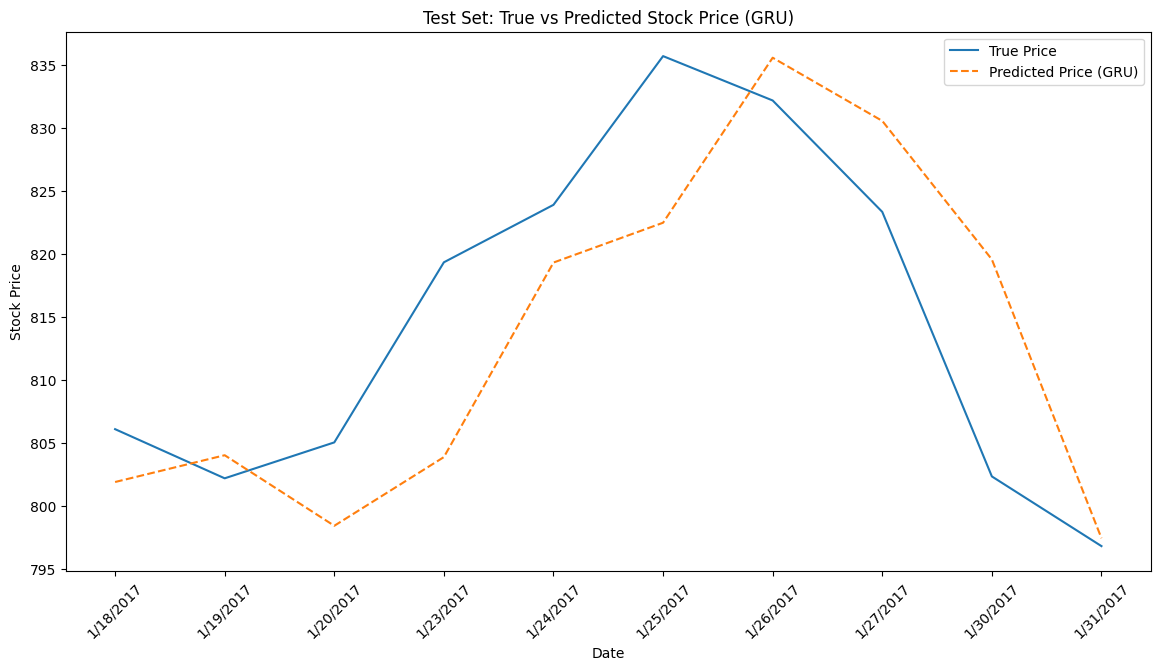

In [ ]:

dates = test_data['Date'][-len(y_test):]  # Get the corresponding date in the test set

# Plotting of real and forecast prices
plt.figure(figsize=(14, 7))
plt.plot(dates, y_test_rescaled, label="True Price")
plt.plot(dates, y_test_pred_rescaled, label="Predicted Price (GRU)", linestyle='--')
plt.title("Test Set: True vs Predicted Stock Price (GRU)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)  # Rotate date labels to avoid overlap
plt.legend()
plt.show()
